In [1]:
import pandas as pd
import xml.etree.ElementTree as et 
import json
import sys

In [2]:
sys.path.append('/Users/37138/cs/capstone')
google_api_key = ""
great_schools_api_key = ""

In [3]:
with open('/Users/37138/cs/capstone/config.json') as json_file:
    data = json.load(json_file)
    google_api_key = data["GOOGLE_API_KEY"]
    great_schools_api_key = data["GREAT_SCHOOLS_API_KEY"]

In [4]:
xtree = et.parse("/Users/37138/cs/capstone/RAW_DATA/school_data.xml")
xroot = xtree.getroot() 

In [5]:
## adapted from https://medium.com/@robertopreste/from-xml-to-pandas-dataframes-9292980b1c1c
def parse_XML(xml_file, df_cols, dtypes = None): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    xtree = et.parse(xml_file)
    xroot = xtree.getroot() 
    rows = []
    
    for node in xroot: 
        res = []
        for el in df_cols: 
            if node is not None and node.find(el) is not None:
                text = node.find(el).text
                if text.isdigit(): 
                    res.append(int(text))
                elif text.isdecimal(): 
                    res.append(float(text))
                else: 
                    res.append(text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})

    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

In [6]:
df_cols = ["gsId", "name", "type", "enrollment", "gsRating", "parentRating", "district", "address", "lat", "lon"]
df = parse_XML("/Users/37138/cs/capstone/RAW_DATA/school_data.xml", df_cols)

In [7]:
df['enrollment'].fillna(df['enrollment'].mean(), inplace=True)

In [8]:
df['gsRating'].fillna(df['gsRating'].mean(), inplace=True)
df['parentRating'].fillna(df['parentRating'].mean(), inplace=True)

In [9]:
df.astype({'enrollment': 'int64', 'gsRating': 'int64', 'parentRating': 'int64', 'lat': 'float', 'lon': 'float'}).dtypes

gsId              int64
name             object
type             object
enrollment        int64
gsRating          int64
parentRating      int64
district         object
address          object
lat             float64
lon             float64
dtype: object

In [10]:
df["gsRating"].describe()

count    200.000000
mean       5.166667
std        1.885322
min        1.000000
25%        5.125000
50%        5.166667
75%        5.166667
max       10.000000
Name: gsRating, dtype: float64

In [11]:
df.isnull().sum()

gsId             0
name             0
type             0
enrollment       0
gsRating         0
parentRating     0
district        92
address          0
lat              0
lon              0
dtype: int64

In [12]:
df.to_csv('school_data_cleaned.csv')

In [13]:
from geopy import distance
from shapely.geometry import Point
import geopandas
import geocoder

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# data mapping 
df['geometry'] = df.apply(lambda row: Point(float(row['lon']), float(row['lat'])), axis=1)
geo = geopandas.GeoDataFrame(df, geometry='geometry')
geo.crs = {'init': 'epsg:4326'}

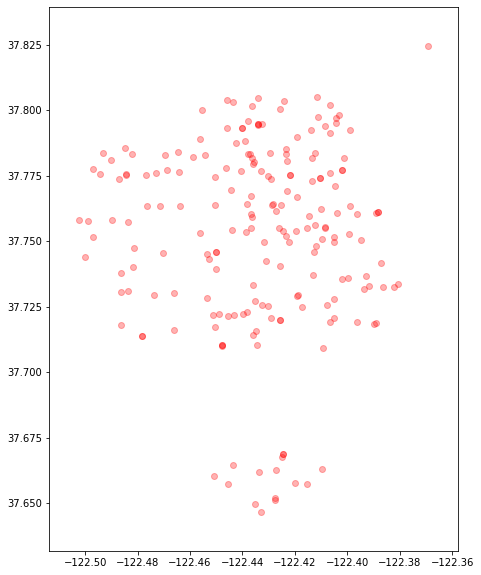

In [16]:
geo.plot(figsize=(13,10), marker="o", color="red", alpha=0.3)

In [17]:
# add sf geojson
sf = geopandas.read_file('/Users/37138/cs/capstone/RAW_DATA/sf.geojson')
sf.crs = {'init': 'epsg:4326'}
sf = sf.rename(columns={'geometry': 'geometry','nhood':'neighborhood_name'}).set_geometry('geometry')

In [18]:
sf["city"] = "San Francisco"

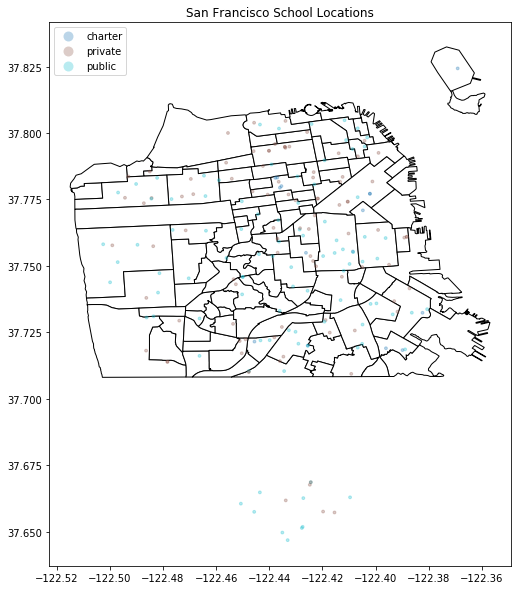

In [19]:
# fig, ax = plt.subplots(1, figsize=(13,10))
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='white', edgecolor='black')
geo.plot(ax=sf_map,column = 'type', marker="o", markersize=8, alpha=0.3, legend=True)
ax.set_title("San Francisco School Locations")
plt.show()

In [20]:
city_boundary = sf.dissolve(by='city')

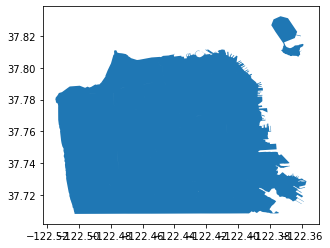

In [21]:
city_boundary.plot()

In [22]:
city_boundary = city_boundary.drop(columns = ['link', 'name'], axis=1)

In [ ]:
city_boundary.to_file("sf_boundary.geojson", driver='GeoJSON')

In [23]:
city_boundary.sindex

In [24]:
geo_boundary = geopandas.tools.sjoin(geo, city_boundary, op = 'within')

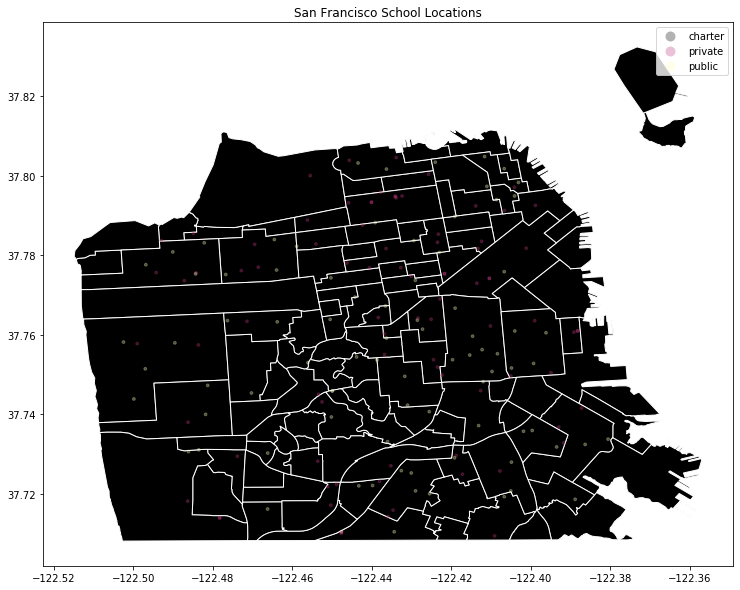

In [32]:
# fig, ax = plt.subplots(1, figsize=(13,10))
fig, ax = plt.subplots(1, figsize=(13,10))
sf_map = sf.plot(ax=ax, color='black', edgecolor='white')
geo_boundary.plot(ax=sf_map,column = 'type', cmap='magma', marker="o", markersize=8, alpha=0.3, legend=True)
ax.set_title("San Francisco School Locations")
plt.show()